In [1]:
SEED = 1234
_EPSILON = 1e-08

In [2]:
import sys
sys.path.append('../scr/')

import pandas as pd
import numpy as np
import torch.nn as nn
import torch
from torch.utils.data import DataLoader
import torch.nn.functional as F
import os
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
import datetime

from ddrsa import DDRSA
import import_data as impt
from utils_eval import c_index, brier_score
from utils_helper import f_get_boosted_trainset
from utils_helper import f_get_risk_predictions, _f_get_pred
from utils_helper import save_checkpoint, load_checkpoint

In [3]:
## for reproducibility
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(SEED)

# Part I: Load the model

### Import Dataset

### load EEG for testing set 1234
load data with high-resolution EEG data (better for visualization)

In [ ]:
## if the combined data with high resolution EEG is already saved as a file, 
## load the test data from a saved file
## if not, run the follow two cells
import pickle
with open('high_res_combined_data_test.pickle', 'rb') as handle:
    te_all_eeg = pickle.load(handle)

In [ ]:
## load the test data from raw
## else, skip the following two cells
import glob
from tqdm import tqdm
import math

## testing patient list with random seed of 1234
te_id_1234 = \
    ['PUH-2019-032', 'PUH-2011-125', 'PUH-2014-216', 'PUH-2014-187', 'PUH-2017-229', 'PUH-2018-046', 'PUH-2013-069', 'PUH-2018-164', 'PUH-2012-210', 'PUH-2015-122', 'PUH-2014-150', 'PUH-2011-163', 'PUH-2015-136', 'PUH-2016-092', 'PUH-2017-027', 'PUH-2013-140', 'PUH-2018-054', 'PUH-2014-174', 'PUH-2019-022', 'PUH-2019-037', 'PUH-2016-048', 'PUH-2014-130', 'PUH-2016-181', 'PUH-2012-158', 'PUH-2010-205', 'PUH-2015-095', 'PUH-2013-194', 'PUH-2011-166', 'PUH-2012-186', 'PUH-2014-211', 'PUH-2011-017', 'PUH-2016-175', 'PUH-2015-270', 'PUH-2013-063', 'PUH-2016-277', 'PUH-2017-296', 'PUH-2019-108', 'PUH-2016-313', 'PUH-2017-098', 'PUH-2011-089', 'PUH-2017-077', 'PUH-2011-071', 'PUH-2016-142', 'PUH-2017-057', 'PUH-2013-165', 'PUH-2016-304', 'PUH-2013-002', 'PUH-2011-154', 'PUH-2013-059', 'PUH-2018-302', 'PUH-2016-080', 'PUH-2018-042', 'PUH-2011-120', 'PUH-2018-167', 'PUH-2017-294', 'PUH-2016-246', 'PUH-2019-124', 'PUH-2016-100', 'PUH-2014-079', 'PUH-2015-293', 'PUH-2011-152', 'PUH-2016-027', 'PUH-2017-181', 'PUH-2012-043', 'PUH-2010-181', 'PUH-2016-257', 'PUH-2010-165', 'PUH-2011-030', 'PUH-2014-106', 'PUH-2012-095', 'PUH-2012-214', 'PUH-2016-242', 'PUH-2012-223', 'PUH-2011-111', 'PUH-2014-060', 'PUH-2013-032', 'PUH-2015-264', 'PUH-2015-207', 'PUH-2017-292', 'PUH-2015-051', 'PUH-2010-140', 'PUH-2014-088', 'PUH-2013-172', 'PUH-2016-324', 'PUH-2015-258', 'PUH-2014-253', 'PUH-2015-295', 'PUH-2017-044', 'PUH-2016-203', 'PUH-2015-019', 'PUH-2017-096', 'PUH-2016-052', 'PUH-2012-083', 'PUH-2018-078', 'PUH-2016-084', 'PUH-2012-032', 'PUH-2013-099', 'PUH-2016-329', 'PUH-2014-249', 'PUH-2010-207', 'PUH-2012-066', 'PUH-2013-061', 'PUH-2012-197', 'PUH-2019-091', 'PUH-2011-075', 'PUH-2017-138', 'PUH-2017-093', 'PUH-2013-166', 'PUH-2010-208', 'PUH-2010-169', 'PUH-2013-208', 'PUH-2015-124', 'PUH-2013-034', 'PUH-2019-059', 'PUH-2015-244', 'PUH-2014-251', 'PUH-2014-227', 'PUH-2013-183', 'PUH-2015-086', 'PUH-2012-188', 'PUH-2017-021', 'PUH-2015-044', 'PUH-2012-183', 'PUH-2015-080', 'PUH-2010-158', 'PUH-2017-011', 'PUH-2013-199', 'PUH-2015-030', 'PUH-2014-093', 'PUH-2010-180', 'PUH-2013-021', 'PUH-2014-241', 'PUH-2016-025', 'PUH-2014-248', 'PUH-2010-150', 'PUH-2010-177', 'PUH-2014-168', 'PUH-2014-184', 'PUH-2018-131', 'PUH-2018-322', 'PUH-2017-213', 'PUH-2015-009', 'PUH-2018-117', 'PUH-2015-282', 'PUH-2013-177', 'PUH-2013-142', 'PUH-2018-245', 'PUH-2016-297', 'PUH-2010-076', 'PUH-2011-139', 'PUH-2014-021', 'PUH-2018-126', 'PUH-2019-040', 'PUH-2013-111', 'PUH-2016-147', 'PUH-2013-019', 'PUH-2013-001', 'PUH-2017-278', 'PUH-2016-248', 'PUH-2014-236', 'PUH-2017-087', 'PUH-2014-083', 'PUH-2016-135', 'PUH-2013-108', 'PUH-2016-064', 'PUH-2018-068', 'PUH-2015-074', 'PUH-2016-125', 'PUH-2010-080', 'PUH-2010-087', 'PUH-2017-008', 'PUH-2019-033', 'PUH-2016-154', 'PUH-2017-222', 'PUH-2010-163', 'PUH-2015-209', 'PUH-2017-146', 'PUH-2013-119', 'PUH-2019-010', 'PUH-2012-153', 'PUH-2015-064', 'PUH-2014-100', 'PUH-2016-087', 'PUH-2012-172', 'PUH-2015-216']

save_path1 = '/heinz-georgenas/EEG/0_6hr_60_avg/'
save_path2 = '/heinz-georgenas/EEG/6_12hr_60_avg/'

saved_files2 = glob.glob(save_path2 + '*.csv')
saved_patients2 = [file.split('/')[-1] for file in saved_files2]
patients_with_more_than_6hr = sorted([file.split('/')[-1][:len('PUH-xxxx-xxx')] for file in saved_files2])

time_to_outcome_path = '/heinz-georgenas/users/xiaobins/eeg/data/Time to outcome.csv'
time_to_outcome = pd.read_csv(time_to_outcome_path)
time_to_outcome.dropna(inplace=True)
time_to_outcome['awake'] = time_to_outcome.follow_com.apply(lambda x: 1 if x=='Yes' else 0)

te_all_eeg = []

for patient in tqdm(te_id_1234):
    first_6hr = pd.read_csv(save_path1+patient+'-12hours.csv', header=None)
    if patient in patients_with_more_than_6hr:
        after_6hr = pd.read_csv(save_path2+patient+'-12hours.csv', header=None)
        curr_X = pd.concat([first_6hr, after_6hr], axis=0)
        curr_X = np.array(curr_X)[:, 2550:2581]
        curr_X = np.concatenate((curr_X[:, :2], curr_X[:, -10:]), axis=1)
        curr_y = np.array(time_to_outcome[time_to_outcome.id==patient][['obsduration', 'awake']]).flatten()
        time = math.floor(curr_y[0] * 60)
        curr_X = curr_X[:time] # do NOT use EEG that are later than time-to-outcome!
    te_all_eeg.append(curr_X)

100%|███████████████████████████████████████████████████| 185/185 [13:01<00:00,  4.22s/it]


In [ ]:
## when running for the first time, save the test data to a file for reuse to save time
import pickle
with open('high_res_combined_data_test.pickle', 'wb') as handle:
    pickle.dump(te_all_eeg,
                handle, protocol=pickle.HIGHEST_PROTOCOL)

### Set Hyper-Parameters

In [7]:
from sklearn.model_selection import ParameterGrid
param_grid = {'dropout': [0.2, 0.3],#, 1e-4], 
              'lr_train': [1e-4, 5e-4, 1e-3],#, 1e-4],
              'beta': [0.5, 1],#, 1e-3],
              'gamma': [0.1, 0.5],
             }
param_grid_list = list(ParameterGrid(param_grid))
print(len(param_grid_list))
param_grid_list

24


[{'beta': 0.5, 'dropout': 0.2, 'gamma': 0.1, 'lr_train': 0.0001},
 {'beta': 0.5, 'dropout': 0.2, 'gamma': 0.1, 'lr_train': 0.0005},
 {'beta': 0.5, 'dropout': 0.2, 'gamma': 0.1, 'lr_train': 0.001},
 {'beta': 0.5, 'dropout': 0.2, 'gamma': 0.5, 'lr_train': 0.0001},
 {'beta': 0.5, 'dropout': 0.2, 'gamma': 0.5, 'lr_train': 0.0005},
 {'beta': 0.5, 'dropout': 0.2, 'gamma': 0.5, 'lr_train': 0.001},
 {'beta': 0.5, 'dropout': 0.3, 'gamma': 0.1, 'lr_train': 0.0001},
 {'beta': 0.5, 'dropout': 0.3, 'gamma': 0.1, 'lr_train': 0.0005},
 {'beta': 0.5, 'dropout': 0.3, 'gamma': 0.1, 'lr_train': 0.001},
 {'beta': 0.5, 'dropout': 0.3, 'gamma': 0.5, 'lr_train': 0.0001},
 {'beta': 0.5, 'dropout': 0.3, 'gamma': 0.5, 'lr_train': 0.0005},
 {'beta': 0.5, 'dropout': 0.3, 'gamma': 0.5, 'lr_train': 0.001},
 {'beta': 1, 'dropout': 0.2, 'gamma': 0.1, 'lr_train': 0.0001},
 {'beta': 1, 'dropout': 0.2, 'gamma': 0.1, 'lr_train': 0.0005},
 {'beta': 1, 'dropout': 0.2, 'gamma': 0.1, 'lr_train': 0.001},
 {'beta': 1, 'dropout

In [8]:
boost_mode = 'ON' #{'ON', 'OFF'}

param = {'batch_size': 32,

         'num_epoch_burn_in': 20,
         'num_epoch': 100,

         'dropout': 0.2, # 1 - keep_prob
         'lr_train': 1e-4,

         'hidden_rnn': 64,
         'hidden_dim_FC': 64,
         'layers_rnn': 2,
         'hidden_att': 2,
         'hidden_cs' : 2,

         'alpha' :1.0,
         'beta'  :1,
         'gamma' :0.1
        }


batch_size = param['batch_size']
num_epoch  = param['num_epoch']

dropout    = param['dropout']
lr_train   = param['lr_train']

hidden_rnn = param['hidden_rnn']
hidden_dim_FC = param['hidden_dim_FC']
layers_rnn = param['layers_rnn']
hidden_att = param['hidden_att']
hidden_cs = param['hidden_cs']

alpha      = param['alpha']
beta       = param['beta']
gamma      = param['gamma']

device     = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


This implementation does not consider missing values.

# Part II: Error bars for CV ROC surve

In [ ]:
'ddrsa_eeg_cr3_1234_alpha1.0_beta5_gamma0.5_BSZ32_Lr0.0001_hiddenRNN64_hiddenFC64_layersRNN2_hiddenAtt2_hiddenCS2_dropout0.4_20230318_0133',
'ddrsa_eeg_cr3_1111_alpha1.0_beta1_gamma0.1_BSZ32_Lr0.0001_hiddenRNN64_hiddenFC64_layersRNN2_hiddenAtt2_hiddenCS2_dropout0.2_20230324_0049',
'ddrsa_eeg_cr3_2222_alpha1.0_beta1_gamma0.1_BSZ32_Lr0.0001_hiddenRNN64_hiddenFC64_layersRNN2_hiddenAtt2_hiddenCS2_dropout0.4_20230317_0946',
'ddrsa_eeg_cr3_3333_alpha1.0_beta1_gamma0.05_BSZ32_Lr0.0001_hiddenRNN64_hiddenFC64_layersRNN2_hiddenAtt2_hiddenCS2_dropout0.4_20230328_0242',
'ddrsa_eeg_cr3_4444_alpha1.0_beta5_gamma0.05_BSZ32_Lr0.0001_hiddenRNN64_hiddenFC64_layersRNN2_hiddenAtt2_hiddenCS2_dropout0.2_20230328_0907',

best_pt_path = 'ddrsa_eeg_cr3_1234_sigmoidFalse_alpha1.0_beta0.5_gamma0.05_BSZ32_Lr0.0001_hiddenRNN64_hiddenFC64_layersRNN2_hiddenAtt3_hiddenCS3_dropout0.4_20230323_1331'


In [14]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
plt.style.use('default')

In [11]:
num_Event

3

### Hour 6

/heinz-georgenas/anaconda3/envs/py39xiaobin/lib/python3.9/site-packages/pycox/preprocessing/label_transforms.py:113: UserWarning: Calling fit method, when 'cuts' are already defined. Leaving cuts unchanged.
  warnings.warn("Calling fit method, when 'cuts' are already defined. Leaving cuts unchanged.")


eval time: 24 

5it [00:06,  1.32s/it]
/tmp/ipykernel_2964573/668318695.py:139: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],


DDRSA (AUC = 0.868 ± 0.031)
eval time: 48 

5it [00:05,  1.19s/it]
/tmp/ipykernel_2964573/668318695.py:139: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],


DDRSA (AUC = 0.863 ± 0.028)
eval time: 72 

5it [00:05,  1.19s/it]
/tmp/ipykernel_2964573/668318695.py:139: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],


DDRSA (AUC = 0.849 ± 0.031)


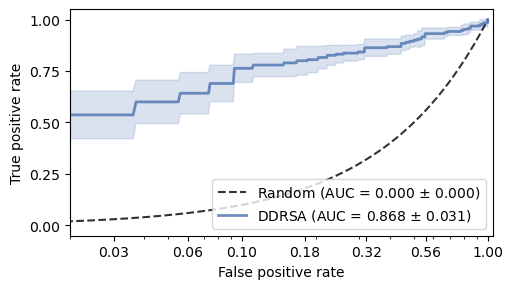

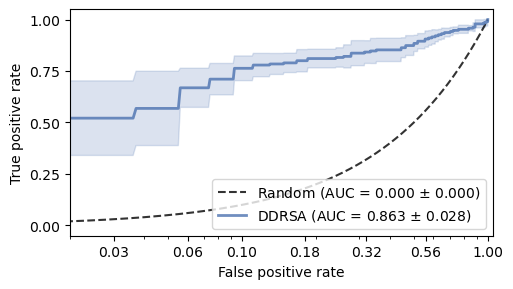

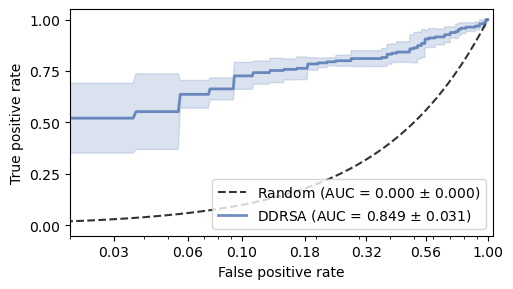

In [17]:
from sklearn import metrics
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
plt.style.use('default')
import matplotlib
import pickle


use_sigmoid = True

seed_list = [1234, 1111, 2222, 3333, 4444]
best_pt_path_list = ['ddrsa_eeg_cr3_1234_alpha1.0_beta5_gamma0.5_BSZ32_Lr0.0001_hiddenRNN64_hiddenFC64_layersRNN2_hiddenAtt2_hiddenCS2_dropout0.4_20230318_0133',
                     'ddrsa_eeg_cr3_1111_alpha1.0_beta1_gamma0.1_BSZ32_Lr0.0001_hiddenRNN64_hiddenFC64_layersRNN2_hiddenAtt2_hiddenCS2_dropout0.2_20230324_0049',
                     'ddrsa_eeg_cr3_2222_alpha1.0_beta1_gamma0.1_BSZ32_Lr0.0001_hiddenRNN64_hiddenFC64_layersRNN2_hiddenAtt2_hiddenCS2_dropout0.4_20230317_0946',
                     'ddrsa_eeg_cr3_3333_alpha1.0_beta1_gamma0.05_BSZ32_Lr0.0001_hiddenRNN64_hiddenFC64_layersRNN2_hiddenAtt2_hiddenCS2_dropout0.4_20230328_0242',
                     'ddrsa_eeg_cr3_4444_alpha1.0_beta5_gamma0.05_BSZ32_Lr0.0001_hiddenRNN64_hiddenFC64_layersRNN2_hiddenAtt2_hiddenCS2_dropout0.2_20230328_0907',
                    ]

data_mode = 'EEG_cr3' # ['EEG_nocr', 'EEG_cr2', 'EEG_cr4']

if data_mode == 'EEG_cr3':
    path = '../../eeg/competing-risk/EEG_processed_data_long_by_death_cat_exclude_3.csv'

(x_dim, x_dim_cont, x_dim_bin), (data, time, label, time_original, time_to_last), \
    (mask1, mask2, mask3), (data_mi), trans_discrete_time = \
                impt.import_dataset(path)

_, num_Event, num_Category  = np.shape(mask1)  # dim of mask3: [subj, Num_Event, Num_Category]
max_length                  = np.shape(data)[1]

pred_time = list(range(1,13))
eval_time = [24, 48, 72]
mean_fpr = np.linspace(1e-10, 1, 1000)

tprs = []
aucs = []

for e, e_time in enumerate(eval_time):
    print('eval time:', e_time, end=' ')
    tprs = []
    aucs = []
    for r, seed in tqdm(enumerate(seed_list)):

        best_pt_path = best_pt_path_list[r]

        ### TRAINING-TESTING SPLIT
        (tr_data,te_data, tr_data_mi, te_data_mi, tr_time,te_time, tr_label,te_label, tr_time_orinal,te_time_original,
         tr_time_to_last,te_time_to_last,
         tr_mask1,te_mask1, tr_mask2,te_mask2, tr_mask3,te_mask3) = \
                train_test_split(data, data_mi, time, label, time_original, time_to_last,
                                 mask1, mask2, mask3, test_size=0.2, stratify=label, random_state=seed) 

        (tr_data,va_data, tr_data_mi, va_data_mi, tr_time,va_time, tr_label,va_label, tr_time_orinal,va_time_original,
         tr_time_to_last, va_time_to_last,
         tr_mask1,va_mask1, tr_mask2,va_mask2, tr_mask3,va_mask3) = \
                train_test_split(tr_data, tr_data_mi, tr_time, tr_label, tr_time_orinal, tr_time_to_last,
                                 tr_mask1, tr_mask2, tr_mask3, test_size=0.2, stratify=tr_label, random_state=seed) 

        model_name = 'ddrsa_eeg_cr3'
        num_Event = 3

        model = \
            DDRSA(input_dim  = x_dim,
                  output_dim = num_Category,
                  layers_rnn = param['layers_rnn'],
                  hidden_rnn = param['hidden_rnn'],
                  long_param = {'layers': 2*[param['hidden_dim_FC']], 'dropout': dropout}, 
                  att_param  = {'layers': param['hidden_att']*[param['hidden_dim_FC']], 'dropout': dropout}, 
                  cs_param   = {'layers': param['hidden_cs']*[param['hidden_dim_FC']], 'dropout': dropout},
                  risks      = num_Event,
                  use_sigmoid = use_sigmoid
                 )
        optimizer = torch.optim.Adam(model.parameters(), lr = lr_train)
        _ = load_checkpoint(f'checkpoints_ddrsa/{model_name}/{best_pt_path}_{seed}.pt', model, optimizer, device)
        model = model.to(device)

        prob_death_all = np.ones((te_data.shape[0], len(pred_time), len(eval_time)))
        prob_awake_all = np.ones((te_data.shape[0], len(pred_time), len(eval_time)))
        risk_death_old_all = np.ones((te_data.shape[0], len(pred_time), len(eval_time)))

        for p, p_time in enumerate(pred_time):
            pred_horizon = int(p_time)
            out = _f_get_pred(model, te_data, p_time, device)
            risk_death_awaken_all_future = 1 - out[:, :2, :pred_horizon].sum((1,2))

            for t, t_time in enumerate(eval_time):
                eval_horizon = int(t_time) + pred_horizon
                risk_death = out[:, 0, pred_horizon:eval_horizon+1].sum(1)
                risk_awake = out[:, 1, pred_horizon:eval_horizon+1].sum(1)
                risk_death_old = risk_death / (risk_death+risk_awake)
                prob_death = risk_death / risk_death_awaken_all_future
                prob_awake = risk_awake / risk_death_awaken_all_future
                prob_death_all[:, p, t] = prob_death
                prob_awake_all[:, p, t] = prob_awake
                risk_death_old_all[:, p, t] = risk_death_old

        mask = (te_label==1) + (te_label==2) # for only people who died naturally, and who awoke

        scores = -(prob_awake_all / prob_death_all)[:, 5, e]
        fpr, tpr, thresholds = metrics.roc_curve(te_label[mask], scores[mask.flatten()], 
                                                 pos_label=1)
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        roc_auc = metrics.auc(fpr, tpr)

        tprs.append(interp_tpr)
        aucs.append(roc_auc)

    n_std = 1
    scale = 'log' # {'log', 'linear'}

    fig = plt.figure(figsize=(12,10))
    ax = fig.add_subplot(3, 2, 1)
    ax.plot(mean_fpr, mean_fpr, linestyle='--', color='black', alpha=.8,
            label=r'%s (AUC = %0.3f $\pm$ %0.3f)' % ('Random', 0, 0))

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = metrics.auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color='b',
            label=r'%s (AUC = %0.3f $\pm$ %0.3f)' % ('DDRSA', mean_auc, n_std*std_auc),
            lw=2, alpha=.8)
    print(r'%s (AUC = %0.3f ± %0.3f)' % ('DDRSA', mean_auc, n_std*std_auc))
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + n_std*std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - n_std*std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='b', alpha=.2)

    plt.xlim([2e-2, 5])
    plt.yticks([0.00,0.25,0.50,0.75,1.00])
    if scale == 'log':
        ax.set_xscale(scale)
        ax.set_xticks([0.03, 0.06, 0.10, 0.18, 0.32, 0.56, 1.00])
        ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

    ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
           # title=r'Mean ROC with $\pm$ %0.1f std. dev.' % (n_std)
          )
    ax.legend(loc='lower right')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    
    auc_info = {'mean_tpr': mean_tpr, 'mean_auc': mean_auc, 'std_auc': std_auc, 'tprs': tprs}
    with open(f'ddrsa_auc_info_{6}_{e_time}.pickle', 'wb') as handle:
        pickle.dump(auc_info,
                    handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    fname = r'ROC_%s_%d_%d.pdf' % ('DDRSA', 6, e_time)
    plt.savefig(fname, dpi=200, format='pdf', bbox_inches='tight')
    # plt.show()
   

/heinz-georgenas/anaconda3/envs/py39xiaobin/lib/python3.9/site-packages/pycox/preprocessing/label_transforms.py:113: UserWarning: Calling fit method, when 'cuts' are already defined. Leaving cuts unchanged.
  warnings.warn("Calling fit method, when 'cuts' are already defined. Leaving cuts unchanged.")


eval time: 24 

5it [00:06,  1.32s/it]
/tmp/ipykernel_2964573/3238421982.py:139: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],


DDRSA (AUC = 0.871 ± 0.015)
eval time: 48 

5it [00:08,  1.71s/it]
/tmp/ipykernel_2964573/3238421982.py:139: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],


DDRSA (AUC = 0.853 ± 0.019)
eval time: 72 

5it [00:05,  1.17s/it]
/tmp/ipykernel_2964573/3238421982.py:139: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],


DDRSA (AUC = 0.822 ± 0.020)


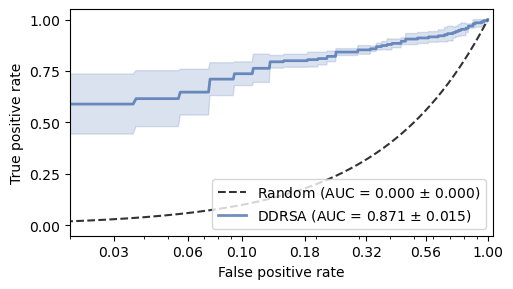

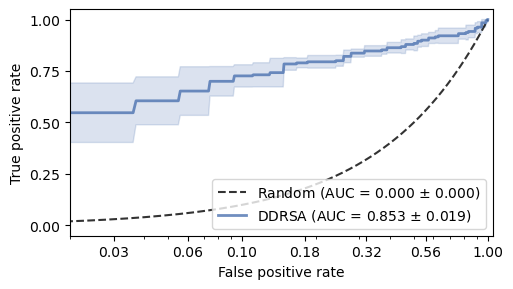

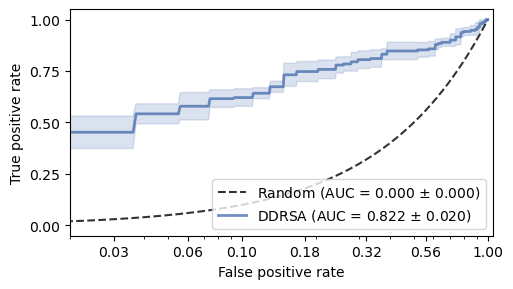

In [18]:
from sklearn import metrics
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
plt.style.use('default')
import matplotlib
import pickle


use_sigmoid = True

seed_list = [1234, 1111, 2222, 3333, 4444]
best_pt_path_list = ['ddrsa_eeg_cr3_1234_alpha1.0_beta5_gamma0.5_BSZ32_Lr0.0001_hiddenRNN64_hiddenFC64_layersRNN2_hiddenAtt2_hiddenCS2_dropout0.4_20230318_0133',
                     'ddrsa_eeg_cr3_1111_alpha1.0_beta1_gamma0.1_BSZ32_Lr0.0001_hiddenRNN64_hiddenFC64_layersRNN2_hiddenAtt2_hiddenCS2_dropout0.2_20230324_0049',
                     'ddrsa_eeg_cr3_2222_alpha1.0_beta1_gamma0.1_BSZ32_Lr0.0001_hiddenRNN64_hiddenFC64_layersRNN2_hiddenAtt2_hiddenCS2_dropout0.4_20230317_0946',
                     'ddrsa_eeg_cr3_3333_alpha1.0_beta1_gamma0.05_BSZ32_Lr0.0001_hiddenRNN64_hiddenFC64_layersRNN2_hiddenAtt2_hiddenCS2_dropout0.4_20230328_0242',
                     'ddrsa_eeg_cr3_4444_alpha1.0_beta5_gamma0.05_BSZ32_Lr0.0001_hiddenRNN64_hiddenFC64_layersRNN2_hiddenAtt2_hiddenCS2_dropout0.2_20230328_0907',
                    ]

data_mode = 'EEG_cr3' # ['EEG_nocr', 'EEG_cr2', 'EEG_cr4']

if data_mode == 'EEG_cr3':
    path = '../../eeg/competing-risk/EEG_processed_data_long_by_death_cat_exclude_3.csv'

(x_dim, x_dim_cont, x_dim_bin), (data, time, label, time_original, time_to_last), \
    (mask1, mask2, mask3), (data_mi), trans_discrete_time = \
                impt.import_dataset(path)

_, num_Event, num_Category  = np.shape(mask1)  # dim of mask3: [subj, Num_Event, Num_Category]
max_length                  = np.shape(data)[1]

pred_time = list(range(1,13))
eval_time = [24, 48, 72]
mean_fpr = np.linspace(1e-10, 1, 1000)

tprs = []
aucs = []

for e, e_time in enumerate(eval_time):
    print('eval time:', e_time, end=' ')
    tprs = []
    aucs = []
    for r, seed in tqdm(enumerate(seed_list)):

        best_pt_path = best_pt_path_list[r]

        ### TRAINING-TESTING SPLIT
        (tr_data,te_data, tr_data_mi, te_data_mi, tr_time,te_time, tr_label,te_label, tr_time_orinal,te_time_original,
         tr_time_to_last,te_time_to_last,
         tr_mask1,te_mask1, tr_mask2,te_mask2, tr_mask3,te_mask3) = \
                train_test_split(data, data_mi, time, label, time_original, time_to_last,
                                 mask1, mask2, mask3, test_size=0.2, stratify=label, random_state=seed) 

        (tr_data,va_data, tr_data_mi, va_data_mi, tr_time,va_time, tr_label,va_label, tr_time_orinal,va_time_original,
         tr_time_to_last, va_time_to_last,
         tr_mask1,va_mask1, tr_mask2,va_mask2, tr_mask3,va_mask3) = \
                train_test_split(tr_data, tr_data_mi, tr_time, tr_label, tr_time_orinal, tr_time_to_last,
                                 tr_mask1, tr_mask2, tr_mask3, test_size=0.2, stratify=tr_label, random_state=seed) 

        model_name = 'ddrsa_eeg_cr3'
        num_Event = 3

        model = \
            DDRSA(input_dim  = x_dim,
                  output_dim = num_Category,
                  layers_rnn = param['layers_rnn'],
                  hidden_rnn = param['hidden_rnn'],
                  long_param = {'layers': 2*[param['hidden_dim_FC']], 'dropout': dropout}, 
                  att_param  = {'layers': param['hidden_att']*[param['hidden_dim_FC']], 'dropout': dropout}, 
                  cs_param   = {'layers': param['hidden_cs']*[param['hidden_dim_FC']], 'dropout': dropout},
                  risks      = num_Event,
                  use_sigmoid = use_sigmoid
                 )
        optimizer = torch.optim.Adam(model.parameters(), lr = lr_train)
        _ = load_checkpoint(f'checkpoints_ddrsa/{model_name}/{best_pt_path}_{seed}.pt', model, optimizer, device)
        model = model.to(device)

        prob_death_all = np.ones((te_data.shape[0], len(pred_time), len(eval_time)))
        prob_awake_all = np.ones((te_data.shape[0], len(pred_time), len(eval_time)))
        risk_death_old_all = np.ones((te_data.shape[0], len(pred_time), len(eval_time)))

        for p, p_time in enumerate(pred_time):
            pred_horizon = int(p_time)
            out = _f_get_pred(model, te_data, p_time, device)
            risk_death_awaken_all_future = 1 - out[:, :2, :pred_horizon].sum((1,2))

            for t, t_time in enumerate(eval_time):
                eval_horizon = int(t_time) + pred_horizon
                risk_death = out[:, 0, pred_horizon:eval_horizon+1].sum(1)
                risk_awake = out[:, 1, pred_horizon:eval_horizon+1].sum(1)
                risk_death_old = risk_death / (risk_death+risk_awake)
                prob_death = risk_death / risk_death_awaken_all_future
                prob_awake = risk_awake / risk_death_awaken_all_future
                prob_death_all[:, p, t] = prob_death
                prob_awake_all[:, p, t] = prob_awake
                risk_death_old_all[:, p, t] = risk_death_old

        mask = (te_label==1) + (te_label==2) # for only people who died naturally, and who awoke

        scores = -(prob_awake_all / prob_death_all)[:, -1, e]
        fpr, tpr, thresholds = metrics.roc_curve(te_label[mask], scores[mask.flatten()], 
                                                 pos_label=1)
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        roc_auc = metrics.auc(fpr, tpr)

        tprs.append(interp_tpr)
        aucs.append(roc_auc)

    n_std = 1
    scale = 'log' # {'log', 'linear'}

    fig = plt.figure(figsize=(12,10))
    ax = fig.add_subplot(3, 2, 1)
    ax.plot(mean_fpr, mean_fpr, linestyle='--', color='black', alpha=.8,
            label=r'%s (AUC = %0.3f $\pm$ %0.3f)' % ('Random', 0, 0))

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = metrics.auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color='b',
            label=r'%s (AUC = %0.3f $\pm$ %0.3f)' % ('DDRSA', mean_auc, n_std*std_auc),
            lw=2, alpha=.8)
    print(r'%s (AUC = %0.3f ± %0.3f)' % ('DDRSA', mean_auc, n_std*std_auc))
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + n_std*std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - n_std*std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='b', alpha=.2)

    plt.xlim([2e-2, 5])
    plt.yticks([0.00,0.25,0.50,0.75,1.00])
    if scale == 'log':
        ax.set_xscale(scale)
        ax.set_xticks([0.03, 0.06, 0.10, 0.18, 0.32, 0.56, 1.00])
        ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

    ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
           # title=r'Mean ROC with $\pm$ %0.1f std. dev.' % (n_std)
          )
    ax.legend(loc='lower right')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    
    auc_info = {'mean_tpr': mean_tpr, 'mean_auc': mean_auc, 'std_auc': std_auc, 'tprs': tprs}
    with open(f'ddrsa_auc_info_{12}_{e_time}.pickle', 'wb') as handle:
        pickle.dump(auc_info,
                    handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    fname = r'ROC_%s_%d_%d.pdf' % ('DDRSA', 12, e_time)
    plt.savefig(fname, dpi=200, format='pdf', bbox_inches='tight')
    # plt.show()
   

# Part III: Test the model

In [81]:
def eval_model(model, te_data, pred_time, eval_time, num_Event, device='cuda'):
    # pred_time = [4, 8, 12]
    # eval_time = [12, 24, 36, 48, 60, 72]

    risk_all = f_get_risk_predictions(model, te_data, pred_time, eval_time, device=device)

    for p, p_time in enumerate(pred_time):
        pred_horizon = int(p_time)
        result1, result2 = np.zeros([num_Event, len(eval_time)]), np.zeros([num_Event, len(eval_time)])

        for t, t_time in enumerate(eval_time):                
            eval_horizon = int(t_time) + pred_horizon
            for k in range(num_Event):
                result1[k, t] = c_index(risk_all[k][:, p, t], te_time, (te_label[:,0] == k+1).astype(int), eval_horizon) #-1 for no event (not comparable)
                result2[k, t] = brier_score(risk_all[k][:, p, t], te_time, (te_label[:,0] == k+1).astype(int), eval_horizon) #-1 for no event (not comparable)

        if p == 0:
            final1, final2 = result1, result2
        else:
            final1, final2 = np.append(final1, result1, axis=0), np.append(final2, result2, axis=0)


    row_header = []
    for p_time in pred_time:
        for k in range(num_Event):
            row_header.append('pred_time {}: event_{}'.format(p_time, k+1))

    col_header = []
    for t_time in eval_time:
        col_header.append('eval_time {}'.format(t_time))

    # c-index result
    df1 = pd.DataFrame(final1, index = row_header, columns=col_header)

    # brier-score result
    df2 = pd.DataFrame(final2, index = row_header, columns=col_header)

    ### PRINT RESULTS
    print('========================================================')
    print('--------------------------------------------------------')
    print('- C-INDEX: ')
    print(df1)
    print('--------------------------------------------------------')
    print('- BRIER-SCORE: ')
    print(df2)
    print('========================================================')
    
    return df1, df2

### three competing risk
- 1: Death (Rearrested, intractable shock, multisystem organ failure; Brain death)
- 2: Awake
- 3: Withdrawal for perceived poor neurological prognosis

In [82]:
seed = SEED

data_mode = 'EEG_cr3' # ['EEG_nocr', 'EEG_cr2', 'EEG_cr4']

if data_mode == 'EEG_nocr':
    path = '../../eeg/varying-seq-len/EEG_processed_data_long.csv'
elif data_mode == 'EEG_cr2':
    path = '../../eeg/competing-risk/EEG_processed_data_long.csv'
elif data_mode == 'EEG_cr4':
    path = '../../eeg/competing-risk/EEG_processed_data_long_by_death_cat.csv'
elif data_mode == 'EEG_cr3':
    path = '../../eeg/competing-risk/EEG_processed_data_long_by_death_cat_exclude_3.csv'

(x_dim, x_dim_cont, x_dim_bin), (data, time, label, time_original, time_to_last), \
    (mask1, mask2, mask3), (data_mi), trans_discrete_time = \
                impt.import_dataset(path)

_, num_Event, num_Category  = np.shape(mask1)  # dim of mask3: [subj, Num_Event, Num_Category]
max_length                  = np.shape(data)[1]

### TRAINING-TESTING SPLIT
(tr_data,te_data, tr_data_mi, te_data_mi, tr_time,te_time, tr_label,te_label, tr_time_orinal,te_time_original,
 tr_time_to_last,te_time_to_last,
 tr_mask1,te_mask1, tr_mask2,te_mask2, tr_mask3,te_mask3) = \
        train_test_split(data, data_mi, time, label, time_original, time_to_last,
                         mask1, mask2, mask3, test_size=0.2, stratify=label, random_state=seed) 

(tr_data,va_data, tr_data_mi, va_data_mi, tr_time,va_time, tr_label,va_label, tr_time_orinal,va_time_original,
 tr_time_to_last, va_time_to_last,
 tr_mask1,va_mask1, tr_mask2,va_mask2, tr_mask3,va_mask3) = \
        train_test_split(tr_data, tr_data_mi, tr_time, tr_label, tr_time_orinal, tr_time_to_last,
                         tr_mask1, tr_mask2, tr_mask3, test_size=0.2, stratify=tr_label, random_state=seed) 

num_Event

/heinz-georgenas/anaconda3/envs/py39xiaobin/lib/python3.9/site-packages/pycox/preprocessing/label_transforms.py:113: UserWarning: Calling fit method, when 'cuts' are already defined. Leaving cuts unchanged.
  warnings.warn("Calling fit method, when 'cuts' are already defined. Leaving cuts unchanged.")


3

#### DDRSA

In [39]:
pred_time = [6,12]
eval_time = [24, 48, 72, 96]
model_name = 'ddrsa_eeg_cr3'

use_sigmoid = False
hidden_att  = 3
hidden_cs   = 3

best_pt_path = 'ddrsa_eeg_cr3_1234_alpha1.0_beta5_gamma0.5_BSZ32_Lr0.0001_hiddenRNN64_hiddenFC64_layersRNN2_hiddenAtt2_hiddenCS2_dropout0.4_20230318_0133'
best_pt_path = 'ddrsa_eeg_cr3_1234_sigmoidFalse_alpha1.0_beta0.5_gamma0.05_BSZ32_Lr0.0001_hiddenRNN64_hiddenFC64_layersRNN2_hiddenAtt3_hiddenCS3_dropout0.4_20230323_1331'
# best_pt_path = 'ddrsa_eeg_cr3_1111_alpha1.0_beta1_gamma0.1_BSZ32_Lr0.0001_hiddenRNN64_hiddenFC64_layersRNN2_hiddenAtt2_hiddenCS2_dropout0.2_20230324_0049'
# best_pt_path = 'ddrsa_eeg_cr3_2222_alpha1.0_beta1_gamma0.1_BSZ32_Lr0.0001_hiddenRNN64_hiddenFC64_layersRNN2_hiddenAtt2_hiddenCS2_dropout0.4_20230317_0946'
# best_pt_path = 'ddrsa_eeg_cr3_3333_alpha1.0_beta1_gamma0.05_BSZ32_Lr0.0001_hiddenRNN64_hiddenFC64_layersRNN2_hiddenAtt2_hiddenCS2_dropout0.4_20230328_0242'
# best_pt_path = 'ddrsa_eeg_cr3_4444_alpha1.0_beta5_gamma0.05_BSZ32_Lr0.0001_hiddenRNN64_hiddenFC64_layersRNN2_hiddenAtt2_hiddenCS2_dropout0.2_20230328_0907'
model = \
    DDRSA(input_dim  = x_dim,
              output_dim = num_Category,
              layers_rnn = param['layers_rnn'],
              hidden_rnn = param['hidden_rnn'],
              long_param = {'layers': 2*[param['hidden_dim_FC']], 'dropout': dropout}, 
              att_param  = {'layers': 3*[param['hidden_dim_FC']], 'dropout': dropout}, 
              cs_param   = {'layers': 3*[param['hidden_dim_FC']], 'dropout': dropout},
              risks      = num_Event,
              use_sigmoid = use_sigmoid
             )
optimizer = torch.optim.Adam(model.parameters(), lr = lr_train)
_ = load_checkpoint(f'checkpoints_ddrsa/{model_name}/{best_pt_path}_{SEED}.pt', model, optimizer, device)
model = model.to(device)

df1, df2 = eval_model(model, te_data, pred_time, eval_time, num_Event)

--------------------------------------------------------
- C-INDEX: 
                       eval_time 24  eval_time 48  eval_time 72  eval_time 96
pred_time 6: event_1       0.671414      0.648041      0.689655      0.724554
pred_time 6: event_2       0.803154      0.847145      0.838727      0.821962
pred_time 6: event_3       0.617995      0.545581      0.603801      0.597442
pred_time 12: event_1      0.759639      0.715438      0.729443      0.727899
pred_time 12: event_2      0.799552      0.787920      0.791343      0.769490
pred_time 12: event_3      0.536557      0.577127      0.607293      0.605910
--------------------------------------------------------
- BRIER-SCORE: 
                       eval_time 24  eval_time 48  eval_time 72  eval_time 96
pred_time 6: event_1       0.038770      0.078816      0.107982      0.122266
pred_time 6: event_2       0.052299      0.099254      0.127955      0.142834
pred_time 6: event_3       0.083791      0.154161      0.190634      0.205454


### c-index

In [40]:
df1[::3] # 1: death

,eval_time 24,eval_time 48,eval_time 72,eval_time 96
pred_time 6: event_1,0.671414,0.648041,0.689655,0.724554
pred_time 12: event_1,0.759639,0.715438,0.729443,0.727899


In [41]:
df1[1::3] # 2: awake

,eval_time 24,eval_time 48,eval_time 72,eval_time 96
pred_time 6: event_2,0.803154,0.847145,0.838727,0.821962
pred_time 12: event_2,0.799552,0.787920,0.791343,0.769490


In [42]:
df1[2::3] # 3: Withdrawal for perceived poor neurological prognosis

,eval_time 24,eval_time 48,eval_time 72,eval_time 96
pred_time 6: event_3,0.617995,0.545581,0.603801,0.597442
pred_time 12: event_3,0.536557,0.577127,0.607293,0.605910
